In [1]:
import time
import pandas as pd
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
import transformers
from transformers import Trainer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler
from transformers import TrainingArguments, DataCollatorWithPadding, BertForSequenceClassification, AdamW
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# EDA part

In [2]:
fake_news_df = pd.read_csv("fake.csv")
fake_news_df["label"] = 0

In [3]:
fake_news_df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [4]:
true_news_df = pd.read_csv("True.csv")
true_news_df["label"] = 1

In [5]:
true_news_df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [51]:
for i, r in true_news_df[12000:].iterrows():
    print(r.text)
    break

DENPASAR, Indonesia (Reuters) - Indonesian police have recaptured a U.S. citizen who escaped a week ago from an overcrowded prison on the holiday island of Bali, the jail s second breakout of foreign inmates this year.  Cristian Beasley from California was rearrested on Sunday, Badung Police chief Yudith Satria Hananta said, without providing further details.  Beasley was a suspect in crimes related to narcotics but had not been sentenced when he escaped from Kerobokan prison in Bali last week. The 32-year-old is believed to have cut through bars in the ceiling of his cell before scaling a perimeter wall of the prison in an area being refurbished. The Kerobokan prison, about 10 km (six miles) from the main tourist beaches in the Kuta area, often holds foreigners facing drug-related charges. Representatives of Beasley could not immediately be reached for comment. In June, an Australian, a Bulgarian, an Indian and a Malaysian tunneled to freedom about 12 meters (13 yards) under Kerobokan

In [7]:
all_news_df = fake_news_df.append(true_news_df).sample(frac=1).reset_index(drop=True)

C:\Users\apache\AppData\Local\Temp\ipykernel_5420\3344768804.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_news_df = fake_news_df.append(true_news_df).sample(frac=1).reset_index(drop=True)


In [8]:
all_news_df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [9]:
all_news_df.subject.value_counts(normalize=True)

politicsNews       0.251058
worldnews          0.225957
News               0.201568
politics           0.152368
left-news          0.099314
Government News    0.034968
US_News            0.017440
Middle-east        0.017328
Name: subject, dtype: float64

In [6]:
all_news_df.groupby(["label", "subject"]).size()

label  subject        
0      Government News     1570
       Middle-east          778
       News                9050
       US_News              783
       left-news           4459
       politics            6841
1      politicsNews       11272
       worldnews          10145
dtype: int64

In [13]:
all_news_df["title_length"] = all_news_df["title"].apply(lambda x: len(x.split()))
all_news_df["text_length"] = all_news_df["text"].apply(lambda x: len(x.split()))
all_news_df.describe()

,label,title_length,text_length
count,44898.000000,44898.000000,44898.000000
mean,0.477015,12.453472,405.282284
std,0.499477,4.111476,351.265595
min,0.000000,1.000000,0.000000
25%,0.000000,10.000000,203.000000
50%,0.000000,11.000000,362.000000
75%,1.000000,14.000000,513.000000
max,1.000000,42.000000,8135.000000


Text(0, 0.5, 'Count')

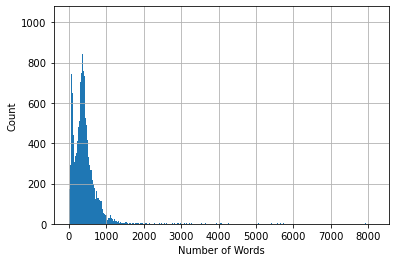

In [23]:
all_news_df["text_length"].hist(bins=1000)
plt.xlabel("Number of Words")
plt.ylabel("Count")

In [8]:
news_df = all_news_df[["text","label"]]
len(news_df)

44898

# preprocess part

In [9]:
news_train_val_df, test_df =  train_test_split(news_df, stratify=all_news_df.label.values, 
                                           random_state=42, test_size=0.95, shuffle=True)

In [10]:
model_name = "roberta-base"
tokenizer = transformers.RobertaTokenizer.from_pretrained(model_name, do_lower_case=True)

In [11]:
tokenizer

PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [12]:
train_val_data = datasets.Dataset.from_pandas(news_train_val_df)
test_data = datasets.Dataset.from_pandas(test_df)

In [13]:
data = train_val_data.train_test_split(test_size=0.2)

In [14]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1795
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 449
    })
})

In [15]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)
tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1795
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 449
    })
})

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments("t", num_train_epochs=1)

In [17]:
model = transformers.RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = (labels == preds).sum()/len(labels)
    return {
        'accuracy': acc,
    }

## Training

In [19]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
E:\Anaconda3\envs\transformer\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1795
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 225


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=225, training_loss=0.0661997816297743, metrics={'train_runtime': 3286.1371, 'train_samples_per_second': 0.546, 'train_steps_per_second': 0.068, 'total_flos': 472239122158560.0, 'train_loss': 0.0661997816297743, 'epoch': 1.0})

In [35]:
select_test_data = test_data.train_test_split(test_size=0.04)
tokenized_test_datasets = select_test_data.map(tokenize_function, batched=True)

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [36]:
tokenized_test_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 40947
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1707
    })
})

## Predict result

In [37]:
predictions = trainer.predict(tokenized_test_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1707
  Batch size = 8


(1707, 2) (1707,)


In [40]:
preds = np.argmax(predictions.predictions, axis=-1)

In [41]:
print(classification_report(predictions.label_ids, preds))
print("ROC AUC Score: {}".format(roc_auc_score(y_true=predictions.label_ids, y_score=preds)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       886
           1       1.00      1.00      1.00       821

    accuracy                           1.00      1707
   macro avg       1.00      1.00      1.00      1707
weighted avg       1.00      1.00      1.00      1707

ROC AUC Score: 0.9993909866017052


In [42]:
model.save_pretrained('./t/')

Configuration saved in ./t/config.json
Model weights saved in ./t/pytorch_model.bin


In [43]:
tokenizer.save_pretrained('./t/')

tokenizer config file saved in ./t/tokenizer_config.json
Special tokens file saved in ./t/special_tokens_map.json


('./t/tokenizer_config.json',
 './t/special_tokens_map.json',
 './t/vocab.json',
 './t/merges.txt',
 './t/added_tokens.json')

In [46]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\apache/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [45]:
! huggingface-cli login

^C


In [1]:
# trainer.push_to_hub()